# IMPORT LIBRARY

In [21]:
# Memuat library-library yang dibutuhkan

import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow Libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image



import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.keras.applications')

# IMPORT DATASET

In [22]:
# Menyiapkan direktori dataset

dir = 'C:\PCD-10\JAGUNG\Dataset'

# DATA UNDERSTANDING

In [23]:
# Proses analisis gambar untuk mendapatkan format, ukuran, dan jumlah channel
def analyze_images(directory):
    image_formats = set()
    max_size = (0, 0)
    min_size = (float('inf'), float('inf'))
    channel_count = None
    image_count = 0

    for root, _, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = cv2.imread(filepath)
                if image is None:
                    continue

                # Dapatkan format gambar
                image_format = filename.split('.')[-1].upper()
                image_formats.add(image_format)
                
                # Dapatkan ukuran gambar
                height, width = image.shape[:2]
                max_size = max(max_size, (width, height))
                min_size = min(min_size, (width, height))

                # Dapatkan jumlah channel
                channels = image.shape[2] if len(image.shape) > 2 else 1
                if channel_count is None:
                    channel_count = channels
                elif channel_count != channels:
                    print("Gambar memiliki jumlah channel yang berbeda.")
                    return

                image_count += 1

    if image_count > 0:
        print(f"Format Data: {', '.join(image_formats)}")
        print(f"Max Ukuran Data: {max_size}")
        print(f"Min Ukuran Data: {min_size}")
        print(f"Ukuran Channel: {channel_count}")
    else:
        print("Tidak ada gambar yang ditemukan.")

# Jalankan analisis
analyze_images(dir)

Format Data: JPEG, JPG
Max Ukuran Data: (5184, 3456)
Min Ukuran Data: (180, 347)
Ukuran Channel: 3


In [24]:
#letak file dan kategori
image_dir = Path(dir)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan lokasi letak file dan kategori
image_df = pd.concat([filepaths, labels], axis=1)

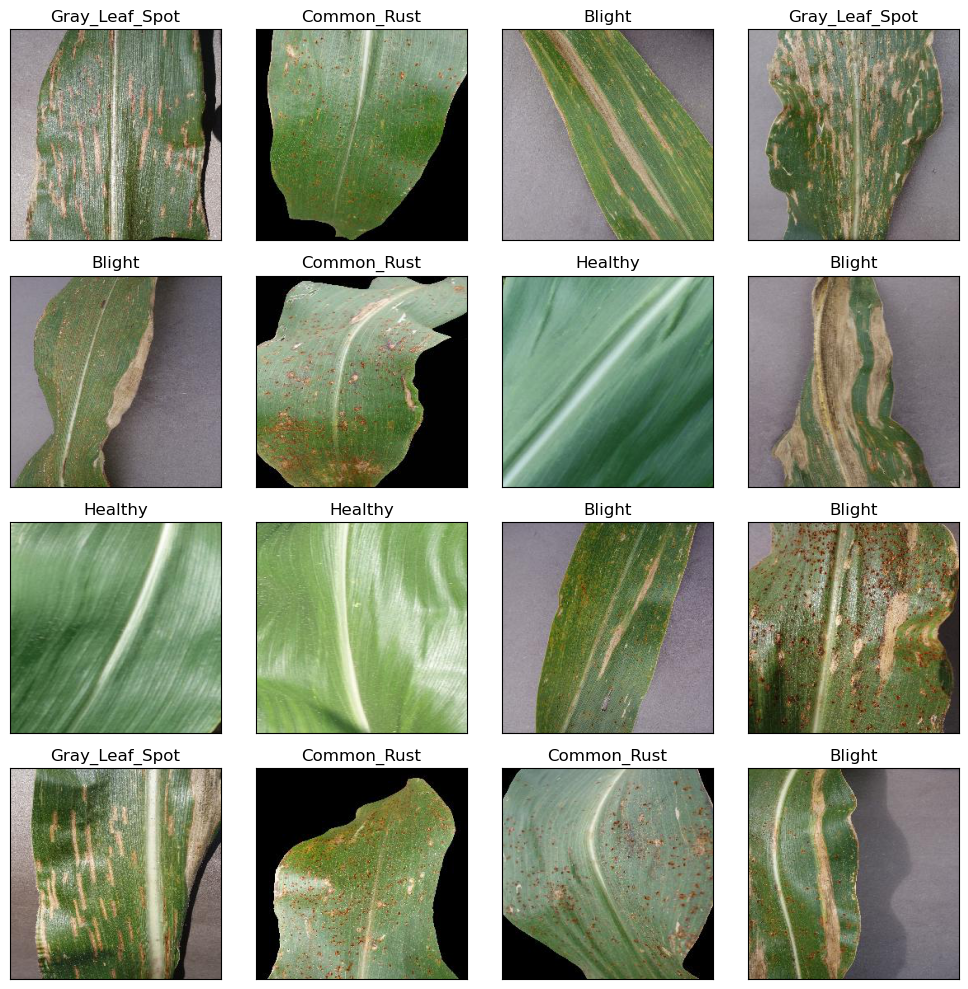

In [25]:
# Menampilkan foto random sesuai kategori
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

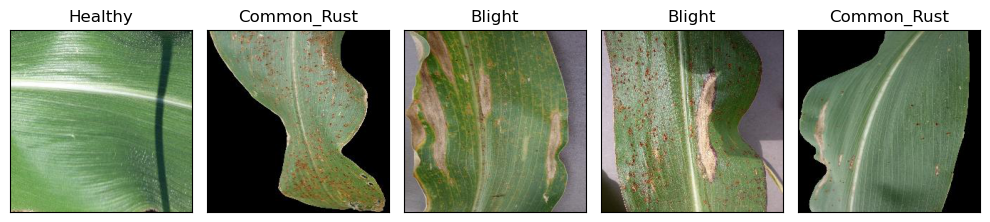

In [26]:
# Menampilkan 5 gambar acak dari kumpulan data beserta labelnya

# Mengubah jumlah indeks acak menjadi 5
random_index = np.random.randint(0, len(image_df), 5)

# Mengubah subplot menjadi 1 baris x 5 kolom
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])

plt.tight_layout()
plt.show()


# DATA PREPARATION

In [27]:
# Memeriksa gambar yang rusak dalam dataset
corrupted_images = []  

for idx, row in image_df.iterrows():
    filepath = row['Filepath']  
    try:
        img = Image.open(filepath) 
        img.verify() 
        img.close()  
    except (IOError, SyntaxError) as e:  
        corrupted_images.append((filepath, str(e)))  

# Menampilkan hasil pemeriksaan
if corrupted_images:  
    print("Gambar yang rusak ditemukan:")
    for filepath, error in corrupted_images:  
        print(f"- {filepath}: {error}")  
else: 
    print("Tidak ada gambar yang rusak ditemukan.")

Tidak ada gambar yang rusak ditemukan.


In [28]:
# Fungsi untuk mendeteksi gambar buram menggunakan metode Laplacian Variance
def is_blurry(image_path, threshold=100):
    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return False
    
    # Ubah gambar menjadi grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Hitung Laplacian Variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Jika laplacian_var lebih kecil dari threshold, gambar dianggap buram
    return laplacian_var < threshold

In [29]:
# Fungsi untuk memeriksa semua gambar dalam folder dan subfolder
def check_blurriness_in_folder(base_folder, threshold=100):
    total_blurry = 0
    total_clear = 0
    
    # Telusuri setiap kelas dalam folder
    for class_folder in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_folder)
        if os.path.isdir(class_path):
            print(f"\nChecking class: {class_folder}")
            
            # Telusuri setiap gambar dalam folder kelas
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    if is_blurry(image_path, threshold):
                        #print(f"Image {image_name} is blurry.")
                        total_blurry += 1
                    else:
                        #print(f"Image {image_name} is clear.")
                        total_clear += 1
    
    # Tampilkan total gambar buram dan tidak buram
    print(f"\nTotal blurry images: {total_blurry}")
    print(f"Total clear images: {total_clear}")

In [30]:
# Path ke folder utama
base_folder = "C:\PCD-10\JAGUNG\Dataset"
# Set threshold sesuai kebutuhan
threshold = 100 

check_blurriness_in_folder(base_folder, threshold)


Checking class: Blight

Checking class: Common_Rust

Checking class: Gray_Leaf_Spot

Checking class: Healthy

Total blurry images: 304
Total clear images: 3884


In [31]:
# pemisahan antara data train dan data test
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42) # dari total 100% dataset diambil 20% untuk testing

In [32]:
# Membagi dataset menjadi data latih dan data uji
train_generator = ImageDataGenerator( 
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
# dari sisa 80% dataset diambil 20% untuk val dan sisanya untuk training
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
) 

In [33]:
# Membagi data menjadi beberapa kategori data (train, val dan test)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5360 validated image filenames belonging to 4 classes.
Found 1339 validated image filenames belonging to 4 classes.
Found 1675 validated image filenames belonging to 4 classes.


In [34]:
# Merubah ukuran gambar dan menyesuaikan nilai warna
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

# MODELING

In [35]:
# Muat model sebelumnya
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [36]:
# Membekukan layer dasar MobileNet agar tidak dilatih ulang
pretrained_model.trainable = False

In [37]:
# Membuat model yang akan dilatih ulang
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(4, activation='softmax')(x)

In [38]:
# Membuat model yang akan dilatih ulang, dengan 2 layer Dense dan Dropout 0.2
model = Model(inputs=inputs, outputs=outputs)

In [39]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Latih model dengan data latih dan validasi
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10
)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 96s 552ms/step - accuracy: 0.8050 - loss: 0.4901 - val_accuracy: 0.9014 - val_loss: 0.2506
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 535ms/step - accuracy: 0.9071 - loss: 0.2348 - val_accuracy: 0.9193 - val_loss: 0.1996
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 538ms/step - accuracy: 0.9216 - loss: 0.1894 - val_accuracy: 0.9246 - val_loss: 0.1874
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 530ms/step - accuracy: 0.9407 - loss: 0.1583 - val_accuracy: 0.9305 - val_loss: 0.1727
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 88s 524ms/step - accuracy: 0.9487 - loss: 0.1344 - val_accuracy: 0.9373 - val_loss: 0.1566
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 533ms/step - accuracy: 0.9597 - loss: 0.1103 - val_accuracy: 0.9432 - val_loss: 0.1490
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 93s 551ms/step - accuracy: 0.9670 - loss: 0.0925 - val_accuracy: 0.9440 - val_loss: 0.1493
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 534ms/step - accuracy: 0.9713 - loss: 0

# EVALUASI

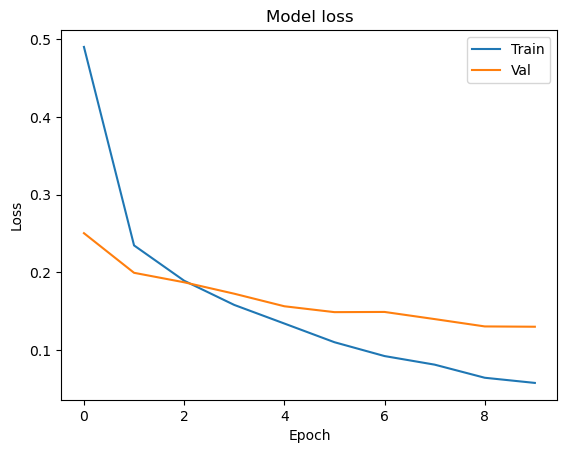

In [41]:
# Membuat plot loss model dengan data latih dan validasi
# untuk memantau kinerja model dalam proses pelatihan
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

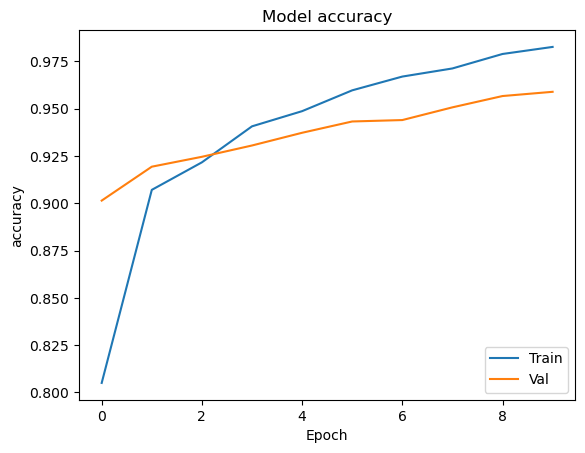

In [42]:
# Membuat plot akurasi dan loss model
# dengan data latih dan validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [43]:
# Prediksi pada data uji
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step


In [44]:
# Mendapatkan label sebenarnya
y_true = test_images.classes

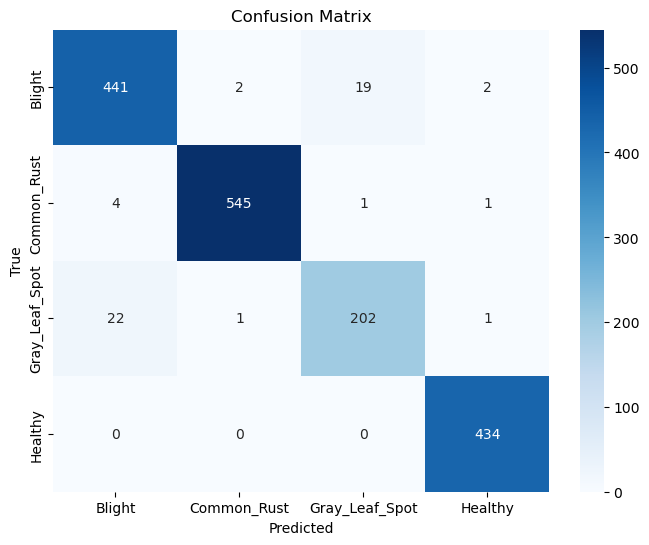

In [45]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_images.class_indices.keys(),
            yticklabels=train_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
# Menghitung akurasi model terhadap data uji
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       464
           1       0.99      0.99      0.99       551
           2       0.91      0.89      0.90       226
           3       0.99      1.00      1.00       434

    accuracy                           0.97      1675
   macro avg       0.96      0.96      0.96      1675
weighted avg       0.97      0.97      0.97      1675



In [47]:
# Menghitung akurasi model terhadap data uji
loss, accuracy = model.evaluate(train_images)
print(f'Akurasi Model: {accuracy*100:.2f}%')

168/168 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.9951 - loss: 0.0277
Akurasi Model: 99.51%


In [48]:
# Menampilkan akurasi model terhadap data latih dan data validasi
loss, accuracy = model.evaluate(val_images)
print(f'Akurasi Validasi: {accuracy*100:.2f}%')

42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 444ms/step - accuracy: 0.9589 - loss: 0.1302
Akurasi Validasi: 95.89%


In [49]:
# Prediksi label tes gambar
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Peta label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Tampilan Hasil
print(f'The first 4 predictions: {pred[:10]}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step
The first 4 predictions: ['Blight', 'Healthy', 'Common_Rust', 'Blight', 'Common_Rust', 'Common_Rust', 'Blight', 'Gray_Leaf_Spot', 'Common_Rust', 'Gray_Leaf_Spot']


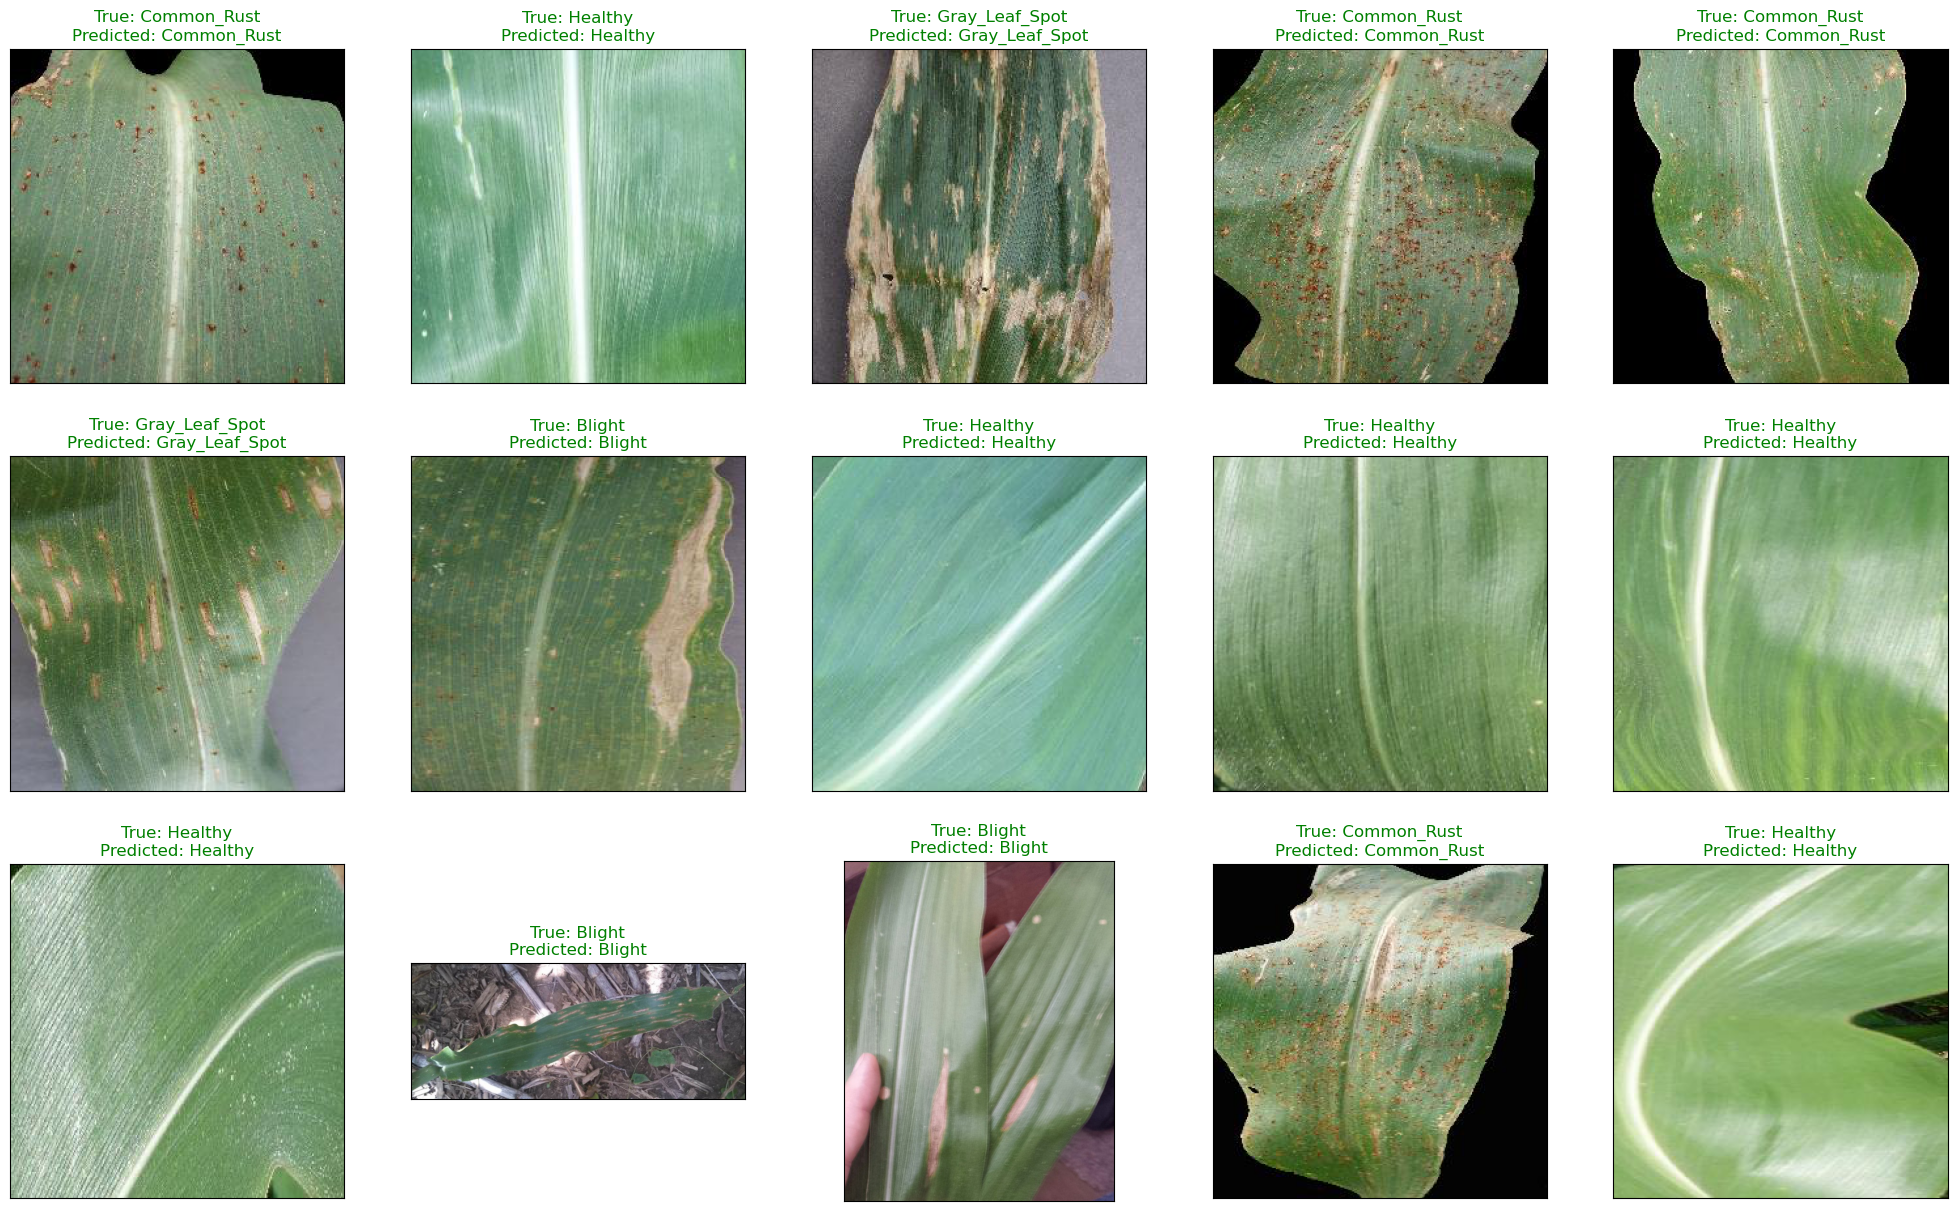

<Figure size 640x480 with 0 Axes>

In [50]:
# Tampilkan 25 gambar acak dari kumpulan data beserta labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

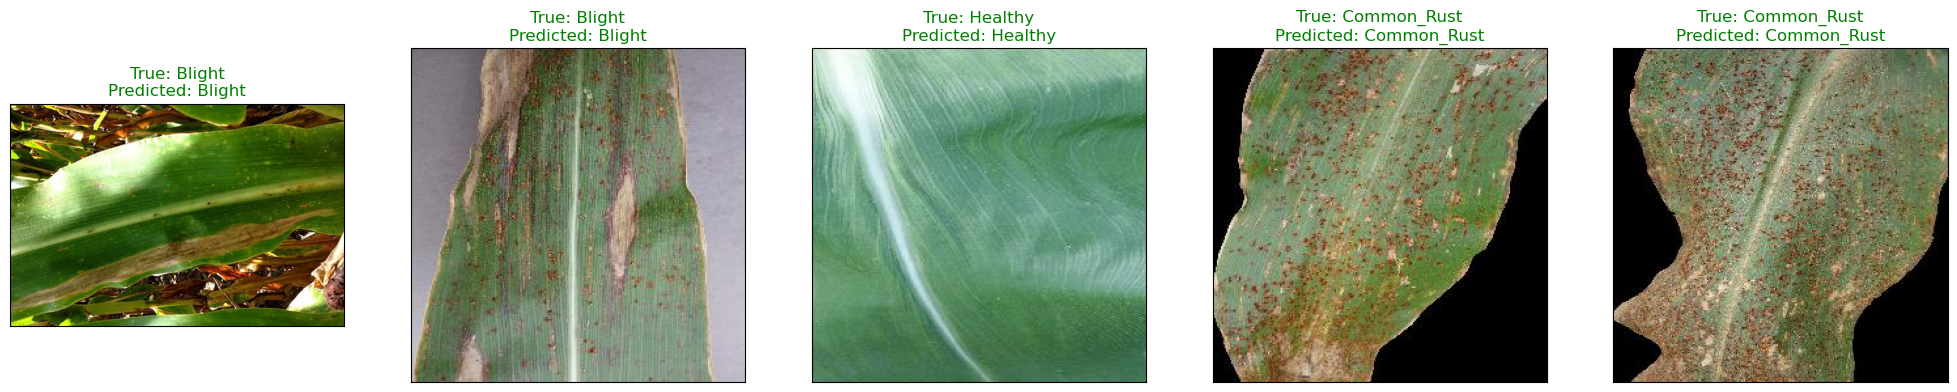

<Figure size 640x480 with 0 Axes>

In [51]:
# Menampilkan 5 gambar acak dari kumpulan data beserta labelnya
# Jumlah indeks acak menjadi 5
random_index = np.random.randint(0, len(test_df) - 1, 5)

# Mengubah subplot menjadi 1 baris x 5 kolom
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.show()
plt.tight_layout()


# SAVE MODEL

In [54]:
# Simpan model yang telah dilatih
dir2 = 'C:\PCD-10\JAGUNG\model_jagung.h5'
model.save(dir2)